# 0. Setup


In [56]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

import random, itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
SEED = 42 # he he 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
train_ds = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_ds = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

val_size = 5000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100.0%
100.0%
100.0%
100.0%


Funkcja do wyświetlania wykresu straty modelu

In [13]:
def show_plot(history):
  plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.plot(history["train_loss"], label="train loss")
  plt.plot(history["val_loss"], label="val loss")
  plt.xlabel("Epoka")
  plt.ylabel("Strata")
  plt.grid()
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history["train_acc"], label="train acc")
  plt.plot(history["val_acc"], label="val acc")
  plt.xlabel("Epoka")
  plt.ylabel("Accuracy")
  plt.grid()
  plt.legend()
  plt.show()

Funkcja do trenowania modelu

In [14]:
def run_epoch(loader, train: bool, model, optimizer, criterion):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

# 1. Testy na prostej sieci neuronowej

Przygotujemy prostą sieć neuronową i zobaczymy jak poradzi sobie z zadaniem. Nasze obrazki są w rozmiarze 28x28 więc pierwszy input musi mieć 784

In [15]:
class SimpleNN(nn.Module):
  def __init__(self):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(256, 64)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x

In [20]:
snn_model = SimpleNN()
EPOCHS = 5
optimizer = Adam(snn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, True, snn_model, optimizer, criterion)
      va_loss, va_acc = run_epoch(test_loader, True, snn_model, optimizer, criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

Ep 01/5 | train loss 0.4385 acc 0.8676 | val loss 0.2649 acc 0.9200
Ep 02/5 | train loss 0.1882 acc 0.9434 | val loss 0.1675 acc 0.9476
Ep 03/5 | train loss 0.1304 acc 0.9609 | val loss 0.1168 acc 0.9631
Ep 04/5 | train loss 0.1063 acc 0.9674 | val loss 0.0938 acc 0.9714
Ep 05/5 | train loss 0.0880 acc 0.9723 | val loss 0.0841 acc 0.9744


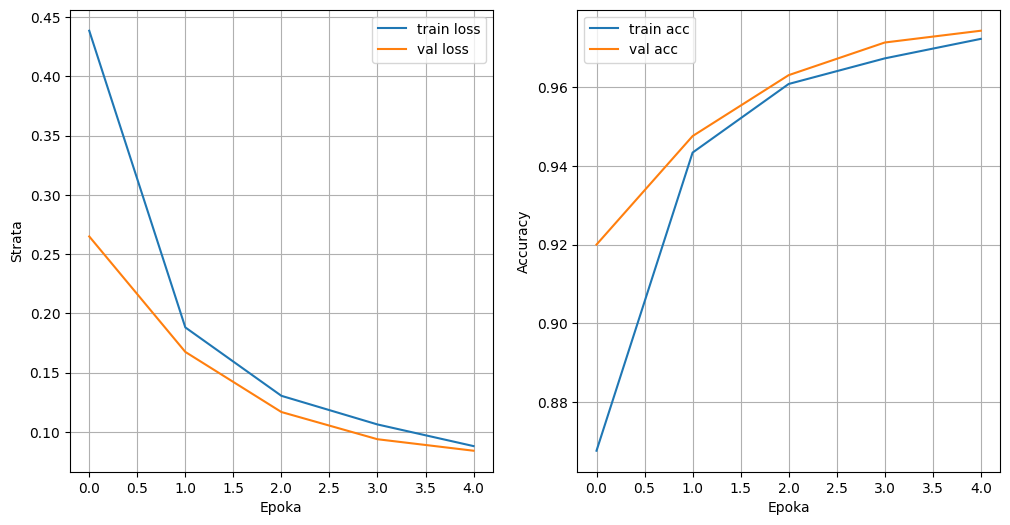

In [21]:
show_plot(history)

Najprostrza sieć neuronowa, wcale nie poradziła sobie tak źle jednak zaraz zobaczymy jak z tym zadaniem poradzi sobie model CNN

# 2. Model CNN

Zaimplementujemy prostą wersje modelu CNN i sprawdzimy jak sobie poradzi.

In [23]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool  = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.25)
    self.fc1  = nn.Linear(64 * 7 * 7, 128)
    self.fc2  = nn.Linear(128, num_classes)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
cnn_model = CNN().to(device)
EPOCHS = 5
optimizer = Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, True, cnn_model, optimizer, criterion)
      va_loss, va_acc = run_epoch(test_loader, True, cnn_model, optimizer, criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

Ep 01/5 | train loss 0.2687 acc 0.9168 | val loss 0.0895 acc 0.9699
Ep 02/5 | train loss 0.0765 acc 0.9767 | val loss 0.0592 acc 0.9811
Ep 03/5 | train loss 0.0578 acc 0.9827 | val loss 0.0427 acc 0.9864
Ep 04/5 | train loss 0.0464 acc 0.9860 | val loss 0.0342 acc 0.9889
Ep 05/5 | train loss 0.0426 acc 0.9868 | val loss 0.0282 acc 0.9906


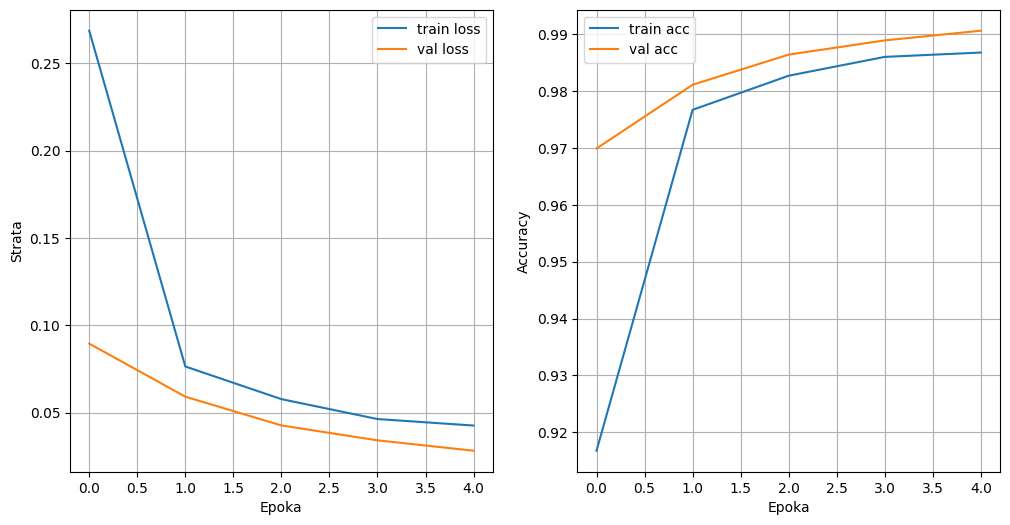

In [25]:
show_plot(history)

Z każda kolejną epoką widzimy poprawę funkcji starty i finalnie dla zbioru treningowego wynosi 0.0426 a walidacyjnego 0.0282. Dokładność dla zbioru walidacyjnego sięga **99%**, więc prosty model CNN poradził sobie z zadaniem ale zaraz go podrasujemy i zobaczymy na co go stać.

# 3. Eksperymenty z siecią CNN

Na początek zmieńmy liczbę kanałów wejściowych i wyjściowych

In [26]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool  = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.25)
    self.fc1  = nn.Linear(128 * 7 * 7, 128)
    self.fc2  = nn.Linear(128, num_classes)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
cnn_model = CNN().to(device)
EPOCHS = 5
optimizer = Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, True, cnn_model, optimizer, criterion)
      va_loss, va_acc = run_epoch(test_loader, True, cnn_model, optimizer, criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

Ep 01/5 | train loss 0.2299 acc 0.9295 | val loss 0.0805 acc 0.9730
Ep 02/5 | train loss 0.0673 acc 0.9799 | val loss 0.0494 acc 0.9831
Ep 03/5 | train loss 0.0492 acc 0.9850 | val loss 0.0339 acc 0.9898
Ep 04/5 | train loss 0.0401 acc 0.9875 | val loss 0.0283 acc 0.9904
Ep 05/5 | train loss 0.0344 acc 0.9893 | val loss 0.0245 acc 0.9924


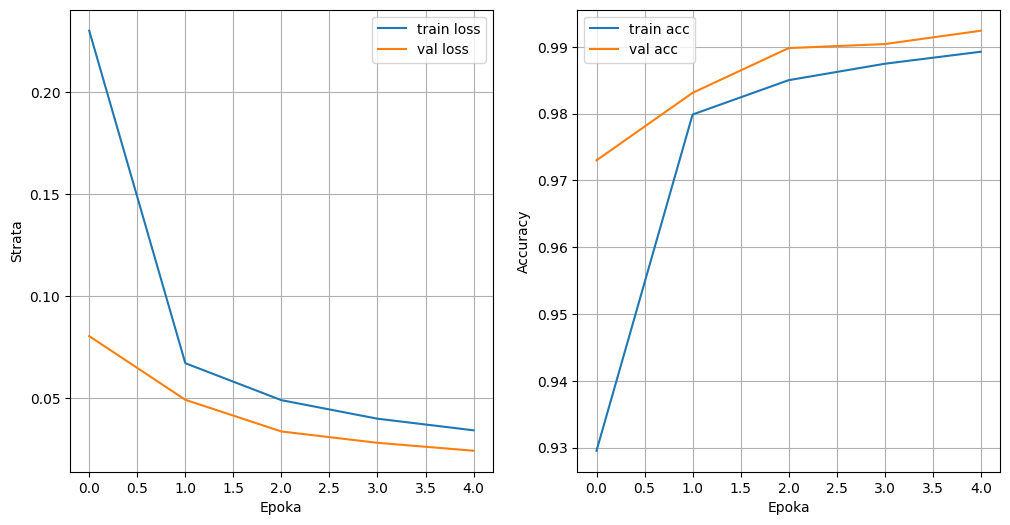

In [28]:
show_plot(history)

Funkcja starty minimalnie się polepszyła, dokładność tak samo ale kompilowało się tyle że można iść do kuchni zrobić sobie coś do picia. Teraz pobawimy się DropOut()

In [33]:
class CNN(nn.Module):
  def __init__(self, dropout_value, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool  = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(dropout_value)
    self.fc1  = nn.Linear(64 * 7 * 7, 128)
    self.fc2  = nn.Linear(128, num_classes)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Wyniki dla Dropout=0.1
Ep 01/5 | train loss 0.2101 acc 0.9379 | val loss 0.0689 acc 0.9779
Ep 02/5 | train loss 0.0538 acc 0.9836 | val loss 0.0354 acc 0.9892
Ep 03/5 | train loss 0.0393 acc 0.9876 | val loss 0.0226 acc 0.9929
Ep 04/5 | train loss 0.0306 acc 0.9902 | val loss 0.0190 acc 0.9929
Ep 05/5 | train loss 0.0236 acc 0.9927 | val loss 0.0183 acc 0.9934


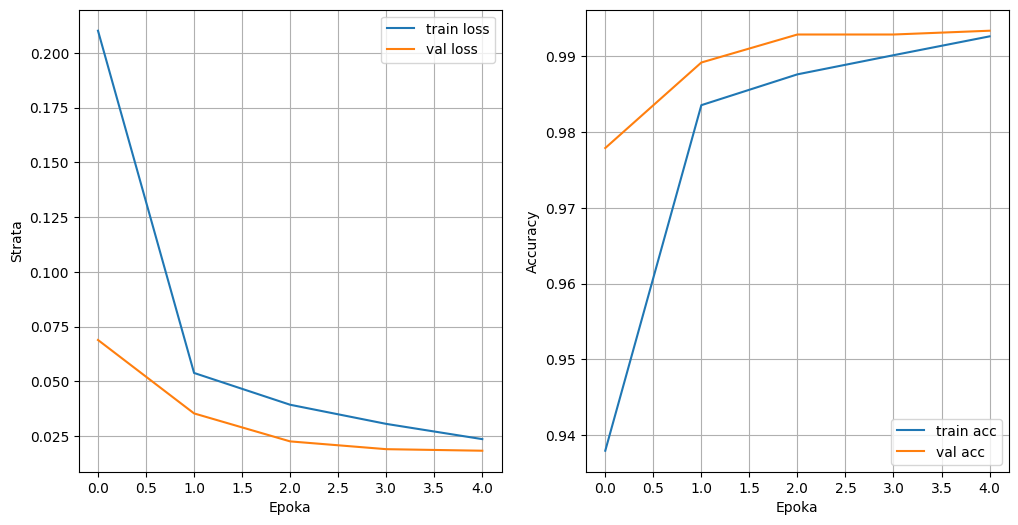


Wyniki dla Dropout=0.2
Ep 01/5 | train loss 0.2394 acc 0.9265 | val loss 0.0762 acc 0.9754
Ep 02/5 | train loss 0.0628 acc 0.9809 | val loss 0.0435 acc 0.9855
Ep 03/5 | train loss 0.0477 acc 0.9855 | val loss 0.0299 acc 0.9904
Ep 04/5 | train loss 0.0372 acc 0.9885 | val loss 0.0304 acc 0.9897
Ep 05/5 | train loss 0.0304 acc 0.9905 | val loss 0.0230 acc 0.9919


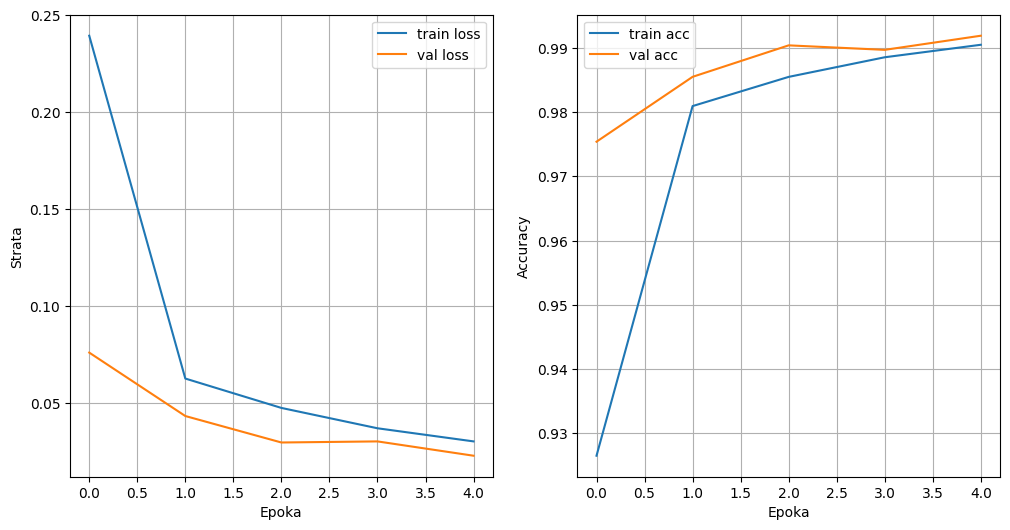


Wyniki dla Dropout=0.3
Ep 01/5 | train loss 0.2549 acc 0.9205 | val loss 0.0905 acc 0.9714
Ep 02/5 | train loss 0.0739 acc 0.9772 | val loss 0.0536 acc 0.9833
Ep 03/5 | train loss 0.0575 acc 0.9826 | val loss 0.0446 acc 0.9864
Ep 04/5 | train loss 0.0473 acc 0.9857 | val loss 0.0345 acc 0.9882
Ep 05/5 | train loss 0.0415 acc 0.9865 | val loss 0.0303 acc 0.9905


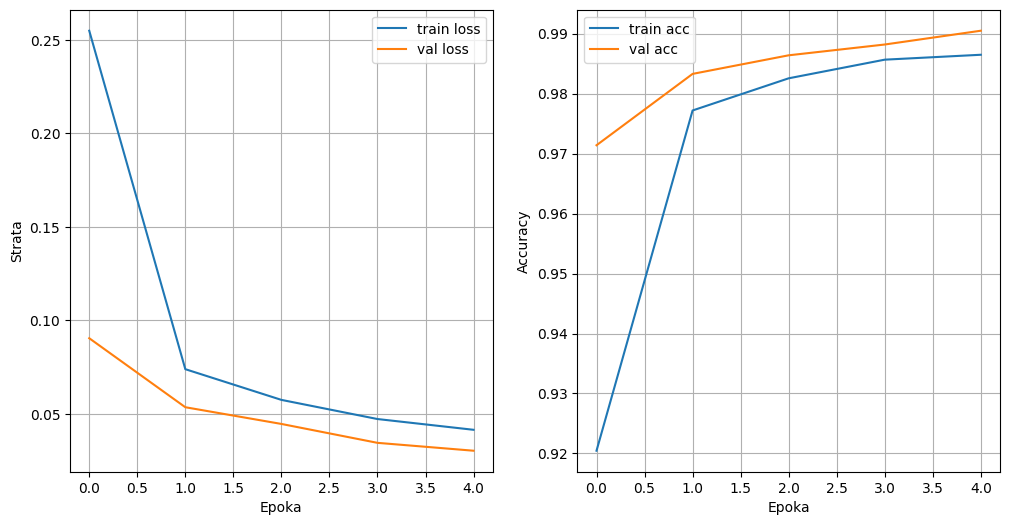


Wyniki dla Dropout=0.4
Ep 01/5 | train loss 0.3013 acc 0.9069 | val loss 0.1032 acc 0.9662
Ep 02/5 | train loss 0.0912 acc 0.9720 | val loss 0.0713 acc 0.9781
Ep 03/5 | train loss 0.0739 acc 0.9778 | val loss 0.0506 acc 0.9831
Ep 04/5 | train loss 0.0627 acc 0.9815 | val loss 0.0446 acc 0.9858
Ep 05/5 | train loss 0.0560 acc 0.9834 | val loss 0.0423 acc 0.9865


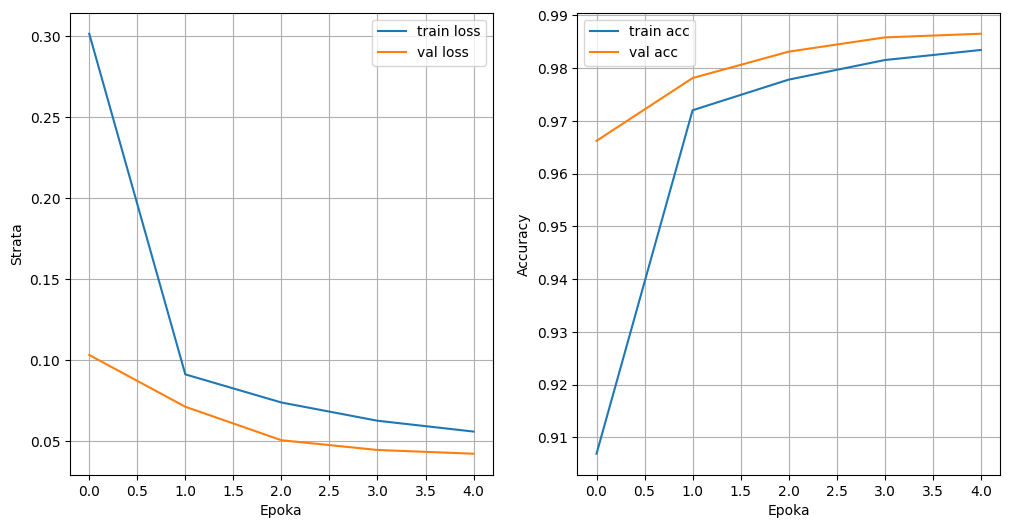


Wyniki dla Dropout=0.5
Ep 01/5 | train loss 0.3391 acc 0.8933 | val loss 0.1356 acc 0.9585
Ep 02/5 | train loss 0.1137 acc 0.9669 | val loss 0.0875 acc 0.9723
Ep 03/5 | train loss 0.0899 acc 0.9723 | val loss 0.0771 acc 0.9754
Ep 04/5 | train loss 0.0771 acc 0.9774 | val loss 0.0636 acc 0.9801
Ep 05/5 | train loss 0.0684 acc 0.9799 | val loss 0.0535 acc 0.9842


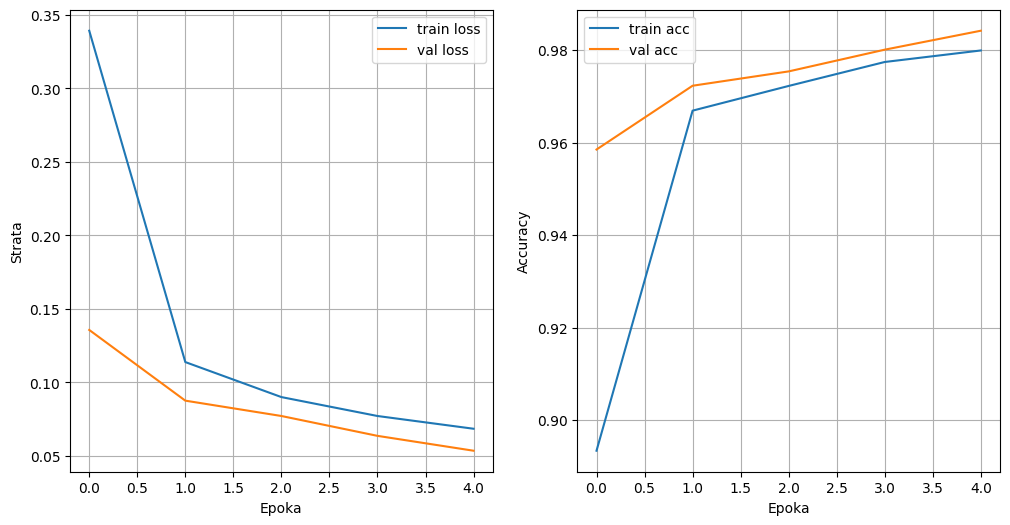

In [37]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
for dropout in dropout_values:
    print(f"\nWyniki dla Dropout={dropout}")
    cnn_model = CNN(dropout).to(device)
    EPOCHS = 5
    optimizer = Adam(cnn_model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = run_epoch(train_loader, True, cnn_model, optimizer, criterion)
        va_loss, va_acc = run_epoch(test_loader, True, cnn_model, optimizer, criterion)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
    show_plot(history)

Najlepsze wyniki dla Dropout = 0.1 dlatego dalej będę używał takiej wartości

In [42]:
class CNN(nn.Module):
  def __init__(self, dropout_value=0.1, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool  = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(dropout_value)
    self.fc1  = nn.Linear(64 * 7 * 7, 128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc2  = nn.Linear(128, num_classes)

  def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [43]:
cnn_model = CNN().to(device)
EPOCHS = 5
optimizer = Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, True, cnn_model, optimizer, criterion)
      va_loss, va_acc = run_epoch(test_loader, True, cnn_model, optimizer, criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

Ep 01/5 | train loss 0.1387 acc 0.9693 | val loss 0.0474 acc 0.9863
Ep 02/5 | train loss 0.0413 acc 0.9881 | val loss 0.0287 acc 0.9912
Ep 03/5 | train loss 0.0292 acc 0.9915 | val loss 0.0202 acc 0.9939
Ep 04/5 | train loss 0.0230 acc 0.9929 | val loss 0.0183 acc 0.9933
Ep 05/5 | train loss 0.0179 acc 0.9946 | val loss 0.0109 acc 0.9974


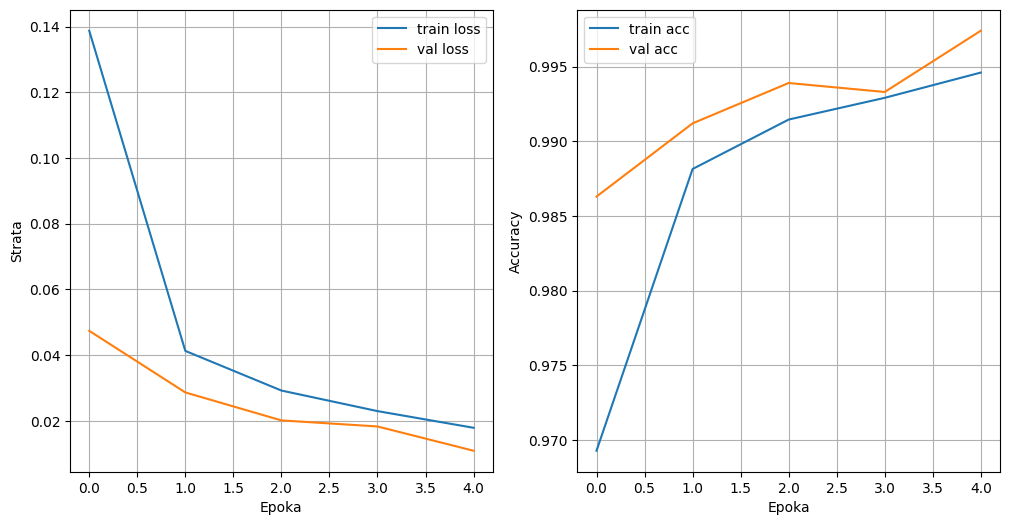

In [44]:
show_plot(history)

Udało się osiągnąć dokładność na poziomie 99.46% dla zbioru treningowego i 99.74% dla zbioru walidacyjnego, który ma stratę bliską 0.01. Myślę, że są to zadowalające wyniki i możemy zrobić ewaluacje naszego modelu

# 4. Ewaluacja

c:\Users\kstol\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9992


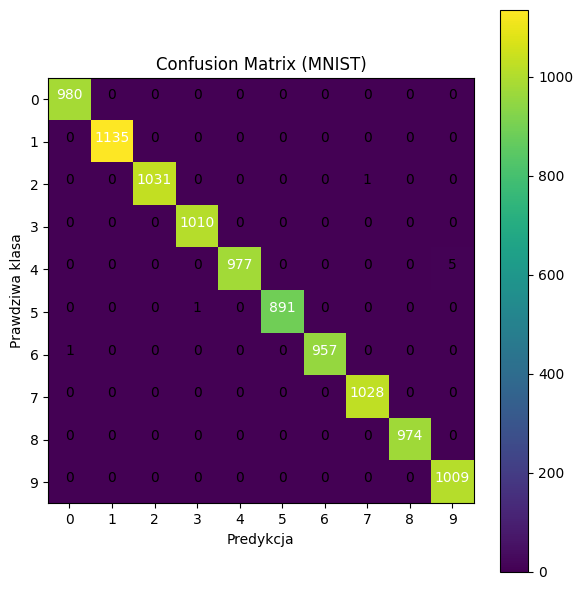

              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995       980
           1     1.0000    1.0000    1.0000      1135
           2     1.0000    0.9990    0.9995      1032
           3     0.9990    1.0000    0.9995      1010
           4     1.0000    0.9949    0.9974       982
           5     1.0000    0.9989    0.9994       892
           6     1.0000    0.9990    0.9995       958
           7     0.9990    1.0000    0.9995      1028
           8     1.0000    1.0000    1.0000       974
           9     0.9951    1.0000    0.9975      1009

    accuracy                         0.9992     10000
   macro avg     0.9992    0.9992    0.9992     10000
weighted avg     0.9992    0.9992    0.9992     10000



In [62]:
import numpy

cnn_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = cnn_model(xb)
        preds = logits.argmax(1).cpu().tolist()
        all_preds.append(preds)
        all_targets.append(yb.cpu().tolist())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Dla zbioru testowego zdażają się pojedyncze pomyłki, jednak wynik w dalszym ciągu jest zadowolający. 